In [1]:
import numpy as np
import pvlib
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from tqdm import tqdm
data_dir =Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')
image_dir = Path('/common/users/vk405/EnergyLab/Data')
proc_data_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData')
df = pd.read_csv(f'{data_dir}/tgtimgs.csv')



In [166]:
def get_absolute_airmass(airmass_relative, pressure=101325.):
    r'''
    Determine absolute (pressure-adjusted) airmass from relative
    airmass and pressure.

    The calculation for absolute airmass (:math:`AM_a`) is

    .. math::
        AM_a = AM_r \frac{P}{101325}

    where :math:`AM_r` is relative air mass at sea level and :math:`P` is
    atmospheric pressure.

    Parameters
    ----------
    airmass_relative : numeric
        The airmass at sea level. [unitless]

    pressure : numeric, default 101325
        Atmospheric pressure. [Pa]

    Returns
    -------
    airmass_absolute : numeric
        Absolute (pressure-adjusted) airmass

    References
    ----------
    .. [1] C. Gueymard, "Critical analysis and performance assessment of
       clear sky solar irradiance models using theoretical and measured
       data," Solar Energy, vol. 51, pp. 121-138, 1993.
    '''

    airmass_absolute = airmass_relative * pressure / 101325.

    return airmass_absolute

In [167]:
def combine_dfs(data_dir,date_start='2012-01-01',date_end='2017-11-30',save=False,\
    files=['20120101.csv','20120601.csv','20150101.csv']):
    to_combine = []
    if not files:
        files = os.listdir(data_dir)
    for file in files:
        df1 = pd.read_csv(data_dir/file).dropna()
        df1.columns.values[[0,2,3]] = ['Date','Dni','Zenith']
        to_combine.append(df1.iloc[:,:])
    df_combine = pd.concat(to_combine,axis=0)
    df_combine['Date'] = pd.to_datetime(df_combine['Date'])
    mask = (df_combine['Date'] >= datetime.strptime(str(date_start), '%Y-%m-%d')) & (df_combine['Date'] <= datetime.strptime(
                str(date_end), '%Y-%m-%d'))
    df_final = df_combine.loc[mask]
    if save:
        df_final.to_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'), index=False)
    return df_final

In [168]:
comb_df = combine_dfs(data_dir/'CSI_data')

In [169]:
comb_df['Date'].iloc[0].strftime('%Y-%m-%d')

'2012-01-01'

In [ ]:
dt_lis = []
for i in tqdm(range(len(comb_df))):
    dt = ' '.join([comb_df.iloc[i]['Date'].strftime('%Y-%m-%d'),comb_df.iloc[i]['MST']])
    dt_lis.append(dt)

In [ ]:
comb_df['DateTime'] = dt_lis

In [ ]:
comb_df.head(2)

,Date,MST,Dni,Zenith,Airmass,DateTime
0,2012-01-01,07:25,1413.778,89.86485,35.97313,2012-01-01 07:25
1,2012-01-01,07:26,1413.778,89.72035,34.03509,2012-01-01 07:26


In [ ]:
df = pd.read_csv(data_dir/'SRRL_measurement_timeseries.csv')

In [ ]:
df.head(2)

,Date,MST,GHI,DateTime
0,2012-01-01,07:25,10.991,2012-01-01 07:25
1,2012-01-01,07:26,12.329,2012-01-01 07:26


In [ ]:
merged_inner = pd.merge(left=df, right=comb_df, left_on='DateTime', right_on='DateTime')

In [ ]:
merged_inner.drop(['Date_y','MST_y'],axis=1,inplace=True)

In [ ]:
merged_inner.columns.values[[0,1]] = ['Date','MST']

In [ ]:
#merged_inner.to_csv(os.path.join(data_dir, 'Full_SRRL_measurement_timeseries.csv'), index=False)

In [ ]:
altitude = 1828.8 
turbidity = 4.0
clear_sky_ghi = []
for i in tqdm(range(len(merged_inner))):
    airmass_abs = get_absolute_airmass(merged_inner.iloc[i]['Airmass'])
    ghi = pvlib.clearsky.ineichen(merged_inner.iloc[i]['Zenith'],airmass_abs,\
            turbidity,altitude,dni_extra=merged_inner.iloc[i]['Dni'])['ghi']
    clear_sky_ghi.append(ghi)

100%|██████████| 1317114/1317114 [06:58<00:00, 3145.22it/s]


In [ ]:

# merged_inner['CSGHI'] = clear_sky_ghi
# merged_inner.to_csv(os.path.join(data_dir, 'Full_SRRL_measurement_timeseries.csv'), index=False)


In [3]:
merged_inner = pd.read_csv(os.path.join(data_dir, 'Full_SRRL_measurement_timeseries.csv'))

In [4]:
(merged_inner['CSGHI']).min()

2.609869239896448e-06

In [ ]:
(merged_inner['CSGHI']).max()

1029.0682113155144

In [ ]:
out = merged_inner['GHI']/merged_inner['CSGHI']
merged_inner['tgt'] = out

In [ ]:
merged_inner['tgt'].quantile(0.97)

7.342885683055639

In [ ]:
inpute_val = merged_inner['tgt'].quantile(0.97)
inpute_val

7.342885683055639

[]

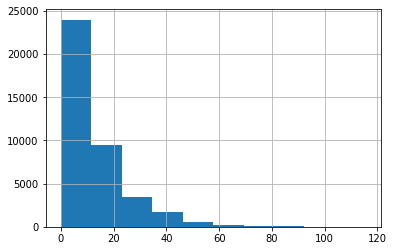

In [ ]:
merged_inner[merged_inner['tgt']>=inpute_val]['GHI'].hist().plot()

In [ ]:
merged_inner['mod_tgt'] = merged_inner['tgt']
merged_inner.loc[merged_inner.index[merged_inner['tgt']>=inpute_val],'mod_tgt'] = inpute_val

[]

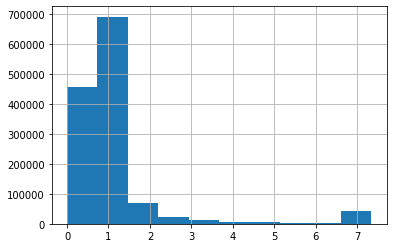

In [ ]:
merged_inner['mod_tgt'].hist().plot()

[]

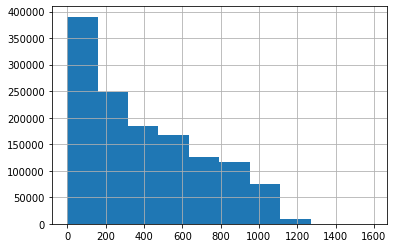

In [ ]:
merged_inner['GHI'].hist().plot()

<AxesSubplot:xlabel='MST'>

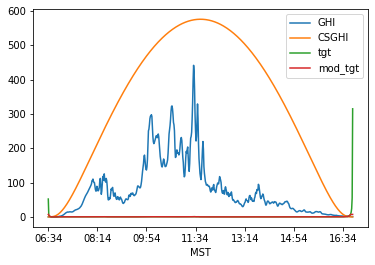

In [ ]:
#due to high correlation between the values the prediction task becomes easy as can be seen in the distribution.


merged_inner[merged_inner['Date'] == '2014-11-03'].plot(x= 'MST',y=['GHI','CSGHI','tgt','mod_tgt'])

<AxesSubplot:>

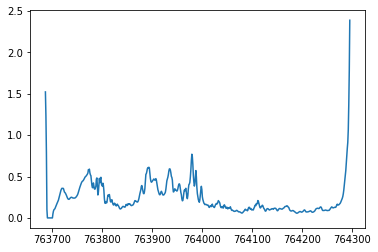

In [ ]:
merged_inner[merged_inner['Date'] == '2014-11-03'][merged_inner[merged_inner['Date'] == '2014-11-03']['mod_tgt']<=3]['mod_tgt'].plot()

In [ ]:
merged_inner['10ma_tgt'] = merged_inner['tgt'].rolling(10).mean().shift(-10)
#rolling(10).mean()

In [ ]:
fin_merged = merged_inner.dropna()

In [ ]:
fin_merged['10ma_tgt'].describe()

count    1.317104e+06
mean     1.599539e+01
std      5.395915e+02
min      0.000000e+00
25%      5.502860e-01
50%      1.010000e+00
75%      1.175444e+00
max      1.088986e+05
Name: 10ma_tgt, dtype: float64

[]

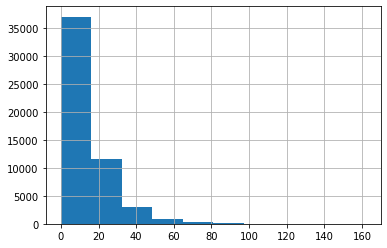

In [ ]:
fin_merged[fin_merged['10ma_tgt']>=fin_merged['10ma_tgt'].quantile(0.96)]['GHI'].hist().plot()

In [171]:
fin_merged.head(3)

,Date,MST,GHI,DateTime,Dni,Zenith,Airmass,CSGHI,tgt,mod_tgt,10ma_tgt
0,2012-01-01,07:25,10.991,2012-01-01 07:25,1413.778,89.86485,35.97313,0.008625,1274.291555,7.342886,129.033106
1,2012-01-01,07:26,12.329,2012-01-01 07:26,1413.778,89.72035,34.03509,0.024549,502.227473,7.342886,80.127671
2,2012-01-01,07:27,13.698,2012-01-01 07:27,1413.778,89.57500,32.22821,0.050222,272.751410,7.342886,53.882535


In [172]:
#fin_merged.to_csv(os.path.join(data_dir, 'Full_SRRL_measurement_timeseries.csv'), index=False)

In [173]:
fin_merged.tail(3)

,Date,MST,GHI,DateTime,Dni,Zenith,Airmass,CSGHI,tgt,mod_tgt,10ma_tgt
1317101,2017-11-30,16:22,11.4936,2017-11-30 16:22,1405.855,88.08384,19.88829,1.714075,6.705424,6.705424,42.211431
1317102,2017-11-30,16:23,10.8756,2017-11-30 16:23,1405.856,88.23911,20.78075,1.360136,7.995967,7.342886,71.184187
1317103,2017-11-30,16:24,10.3137,2017-11-30 16:24,1405.856,88.39391,21.74016,1.059466,9.734807,7.342886,164.812736


In [57]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')

In [175]:
base_df.head(2)

,Date,MST,Imgs,Target
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.5878
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.4806


In [176]:
base_df.dtypes

Date       object
MST        object
Imgs       object
Target    float64
dtype: object

In [188]:
base_dts = []

for i in tqdm(range(len(base_df))):
    dt = ' '.join([base_df.iloc[i]['Date'],base_df.iloc[i]['MST']])
    base_dts.append(dt)
    
    

100%|██████████| 100887/100887 [00:14<00:00, 6805.26it/s]


In [194]:
len(base_dts)

100887

In [196]:
base_df['DateTime'] = base_dts

In [203]:
base_df_ddp = base_df.drop_duplicates(subset=['DateTime'])
fin_merged_ddp = fin_merged.drop_duplicates(subset=['DateTime'])

In [207]:
comb_tgt = pd.merge(left=base_df_ddp, right=fin_merged_ddp, left_on='DateTime', right_on='DateTime')

In [209]:
len(comb_tgt)

100885

In [212]:
comb_tgt.drop(labels=['Date_y','MST_y'],axis=1,inplace=True)

In [214]:
comb_tgt.columns.values[[0,1]] = ['Date','MST']

In [216]:

#comb_tgt.to_csv(os.path.join(data_dir, 'tgtimgs.csv'), index=False)
#data_dir}/tgtimgs.csv'

In [218]:
comb_tgt.head(3)

,Date,MST,Imgs,Target,DateTime,GHI,Dni,Zenith,Airmass,CSGHI,tgt,mod_tgt,10ma_tgt
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.5878,2012-01-01 07:40,20.072,1413.778,87.61860,17.57278,3.135137,6.402271,6.402271,3.900481
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.4806,2012-01-01 07:50,32.264,1413.778,86.07792,12.48786,11.912806,2.708346,2.708346,2.203238
2,2012-01-01,08:00,['/common/users/vk405/EnergyLab/Data/20120101/...,68.4412,2012-01-01 08:00,54.900,1413.778,84.54333,9.58421,26.702780,2.055966,2.055966,1.860471


In [6]:
np.corrcoef(comb_tgt['GHI'],comb_tgt['CSGHI'])

array([[1.       , 0.6257823],
       [0.6257823, 1.       ]])

In [2]:
comb_tgt = pd.read_csv(os.path.join(data_dir, 'tgtimgs.csv'))

In [3]:
comb_tgt['10ma_tgt'].describe()

count    100885.000000
mean          3.044470
std         142.362152
min           0.000000
25%           0.533611
50%           0.996001
75%           1.115014
max       27786.416545
Name: 10ma_tgt, dtype: float64

In [5]:
np.corrcoef(x = comb_tgt['Target'],y = comb_tgt['10ma_tgt'])

array([[ 1.        , -0.02135687],
       [-0.02135687,  1.        ]])

In [6]:
comb_tgt['10ma_tgt'].quantile(0.99)

3.571555706400608

In [225]:
comb_tgt['10ma_tgt'].quantile(0.99)

3.571555706400608

In [8]:
comb_tgt['10ma_tgt'].quantile(0.999)

375.05655548438006

[]

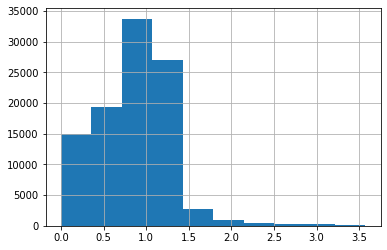

In [10]:
comb_tgt[comb_tgt['10ma_tgt']<=comb_tgt['10ma_tgt'].quantile(0.99)]['10ma_tgt'].hist().plot()

[]

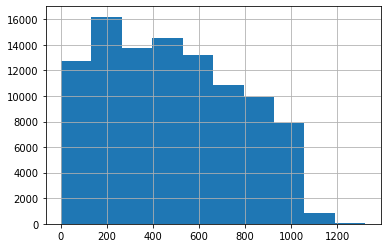

In [15]:
comb_tgt[comb_tgt['10ma_tgt']<=comb_tgt['10ma_tgt'].quantile(0.99)]['Target'].hist().plot()

99876

In [18]:
comb_tgt

,Date,MST,Imgs,Target,DateTime,GHI,Dni,Zenith,Airmass,CSGHI,tgt,mod_tgt,10ma_tgt
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.58780,2012-01-01 07:40,20.0720,1413.778,87.61860,17.57278,3.135137,6.402271,6.402271,3.900481
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.48060,2012-01-01 07:50,32.2640,1413.778,86.07792,12.48786,11.912806,2.708346,2.708346,2.203238
2,2012-01-01,08:00,['/common/users/vk405/EnergyLab/Data/20120101/...,68.44120,2012-01-01 08:00,54.9000,1413.778,84.54333,9.58421,26.702780,2.055966,2.055966,1.860471
3,2012-01-01,08:10,['/common/users/vk405/EnergyLab/Data/20120101/...,89.95900,2012-01-01 08:10,77.5730,1413.779,83.02945,7.75703,46.028014,1.685343,1.685343,1.557430
4,2012-01-01,08:20,['/common/users/vk405/EnergyLab/Data/20120101/...,100.74350,2012-01-01 08:20,99.5010,1413.779,81.54404,6.51961,68.362607,1.455489,1.455489,1.246774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100880,2017-11-30,15:20,['/common/users/vk405/EnergyLab/Data/20171130/...,161.97970,2017-11-30 15:20,178.5480,1405.835,78.60572,4.94447,118.342626,1.508738,1.508738,1.558826
100881,2017-11-30,15:30,['/common/users/vk405/EnergyLab/Data/20171130/...,133.98670,2017-11-30 15:30,150.5350,1405.839,80.06339,5.61915,92.507951,1.627266,1.627266,1.705357
100882,2017-11-30,16:00,['/common/users/vk405/EnergyLab/Data/20171130/...,47.26993,2017-11-30 16:00,68.9675,1405.848,84.63234,9.71726,25.555628,2.698721,2.698721,2.682461
100883,2017-11-30,16:10,['/common/users/vk405/EnergyLab/Data/20171130/...,15.55378,2017-11-30 16:10,18.9934,1405.852,86.20132,12.79288,10.912339,1.740544,1.740544,3.059256


[]

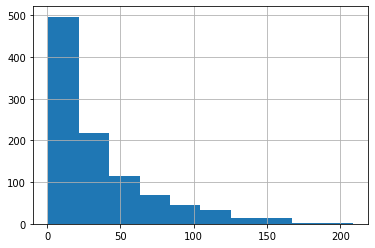

In [14]:
comb_tgt[comb_tgt['10ma_tgt']>comb_tgt['10ma_tgt'].quantile(0.99)]['GHI'].hist().plot()

In [4]:
b_df = pd.read_csv(os.path.join(data_dir, 'Full_SRRL_measurement_timeseries.csv'))

In [20]:
b_df['DateTime'] = pd.to_datetime(b_df['DateTime'])

In [5]:

base_df = pd.read_csv(os.path.join(data_dir, 'tgtimgs.csv'))
base_df.head(3)


,Date,MST,Imgs,Target,DateTime,GHI,Dni,Zenith,Airmass,CSGHI,tgt,mod_tgt,10ma_tgt
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.5878,2012-01-01 07:40,20.072,1413.778,87.61860,17.57278,3.135137,6.402271,6.402271,3.900481
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.4806,2012-01-01 07:50,32.264,1413.778,86.07792,12.48786,11.912806,2.708346,2.708346,2.203238
2,2012-01-01,08:00,['/common/users/vk405/EnergyLab/Data/20120101/...,68.4412,2012-01-01 08:00,54.900,1413.778,84.54333,9.58421,26.702780,2.055966,2.055966,1.860471


In [7]:
import datetime as dt
#from datetime import datetime
dt.datetime.fromisoformat("2012-01-01 07:30")

datetime.datetime(2012, 1, 1, 7, 30)

In [11]:
end = dt.datetime.fromisoformat(base_df.iloc[0]['DateTime'])

st = end-dt.timedelta(minutes=10)

In [14]:
st

datetime.datetime(2012, 1, 1, 7, 30)

In [15]:
b_df['DateTime'] = pd.to_datetime(b_df['DateTime'])

In [16]:
t = b_df[(b_df['DateTime'] > st) & (b_df['DateTime'] <= end)]['GHI']

In [26]:
len(t)

10

In [17]:
miss = []
for i in tqdm(range(len(base_df))):
    end = dt.datetime.fromisoformat(base_df.iloc[i]['DateTime'])
    st = end-dt.timedelta(minutes=10)
    t = b_df[(b_df['DateTime'] > st) & (b_df['DateTime'] <= end)]['GHI']
    if len(t) != 10:
        miss.append(end)
        

    

  3%|▎         | 2869/100885 [00:17<10:28, 155.99it/s]

In [ ]:
len(miss)

In [ ]:
miss

In [1]:
miss

NameError: name 'miss' is not defined

In [33]:
b_df['GHI'].clip(upper=1250.0,lower=0.0)

0          10.9910
1          12.3290
2          13.6980
3          15.0070
4          15.5160
            ...   
1317099    12.9467
1317100    12.2368
1317101    11.4936
1317102    10.8756
1317103    10.3137
Name: GHI, Length: 1317104, dtype: float64

In [41]:
base_df['10ma_tgt'].quantile([0.0,0.9,0.95,0.99,0.999])

0.000      0.000000
0.900      1.267987
0.950      1.501955
0.990      3.571556
0.999    375.056555
Name: 10ma_tgt, dtype: float64

In [15]:
#checking trained model

df = pd.read_csv('/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/csvlogs/trail/metrics.csv')

<AxesSubplot:>

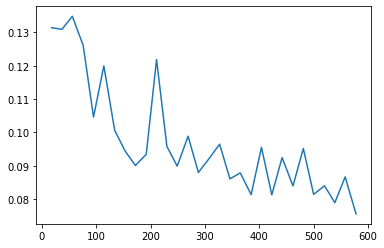

In [16]:
df['val_loss'].dropna().plot()

In [17]:
df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))

In [18]:
df_svd

,Date,MST,GHI,DateTime
0,2012-01-01,07:25,10.99100,2012-01-01 07:25
1,2012-01-01,07:26,12.32900,2012-01-01 07:26
2,2012-01-01,07:27,13.69800,2012-01-01 07:27
3,2012-01-01,07:28,15.00700,2012-01-01 07:28
4,2012-01-01,07:29,15.51600,2012-01-01 07:29
...,...,...,...,...
1577916,2017-11-30,16:30,7.39022,2017-11-30 16:30
1577917,2017-11-30,16:31,6.93717,2017-11-30 16:31
1577918,2017-11-30,16:32,6.44949,2017-11-30 16:32
1577919,2017-11-30,16:33,5.92687,2017-11-30 16:33


In [ ]:

class Dset(Dataset):
    def __init__(self,split= 'train',data_dir='/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/',
    image_dir='/common/users/vk405/EnergyLab/Data/ProcData',seq_length=10):
        self.split = split

        #hardcoded dir locs 
        self.data_dir = Path(data_dir)
        self.image_dir = Path(image_dir) 
        self.seq_length = seq_length
        
        base_df = pd.read_csv(f'{self.data_dir}/tgtimgs.csv')
        #remove outliers
        base_df['GHI'] = b_df['GHI'].clip(upper=1250.0,lower=0.0)
        base_df['10ma_tgt'] = b_df['10ma_tgt'].clip(upper=base_df['10ma_tgt'].quantile,lower=0.0)


        full_df = pd.read_csv(f'{self.data_dir}/Full_SRRL_measurement_timeseries.csv')
        full_df['GHI'] = full_df['GHI'].clip(upper=1250.0,lower=0.0)
                
        trn_base_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
        trn_full_df = pd.DataFrame(base_df.loc[pd.to_datetime(full_df['Date']).dt.year <= 2014])
        
        trn_x,trn_y = extract(trn_base_df,trn_full_df)


        scalar = MinMaxScaler().fit(trn_x.reshape(-1,1))

        scalar_tgt = MinMaxScaler().fit(trn_y.reshape(-1,1))

        if self.split == 'train':
            self.base_df,self.full_df = trn_base_df,trn_full_df

        
        elif self.split == 'valid':
            self.base_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year == 2015])
            self.full_df = pd.DataFrame(base_df.loc[pd.to_datetime(full_df['Date']).dt.year == 2015])
        
        else:
            self.base_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year > 2015])
            self.full_df = pd.DataFrame(base_df.loc[pd.to_datetime(full_df['Date']).dt.year > 2015])
        
            
        

            

        x,y = self.extract(self.base_df,self.full_df)
        r,c = x.shape
        self.x = np.squeeze(scalar.transform(trn_x.reshape(-1,1))).reshape(r,c)
        self.y = np.squeeze(scalar_tgt.transform(trn_y.reshape(-1,1)))
            
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self,ind):
        return self.x[ind].reshape(-1,1),self.y[ind]

    def extract(self,base_df,full_df):
        xs = []
        ys = []
        for i in tqdm(range(len(base_df))):
            end = dt.datetime.fromisoformat(base_df.iloc[i]['DateTime'])
            st = end-dt.timedelta(minutes=self.seq_length)
            t = full_df[(b_df['DateTime'] > st) & (full_df['DateTime'] <= end)]['GHI']
            xs.append(t.values)
            ys.append(base_df.iloc[i]['10ma_tgt'])
            if len(t) != 10:
                miss.append(end)

    

    def sliding_windows(self,data, seq_length):
        x = []
        y = []
        dates = sorted(set(data['Date']))
        for date in tqdm(dates):
            #print(date)
            dt_data = data[data['Date'].isin([date])]
            for i in range(len(dt_data)-seq_length-1):
                _x = dt_data.iloc[i:(i+seq_length)]['norm_GHI']
                _y = dt_data.iloc[i+seq_length-1]['norm_Target']
                x.append(_x)
                y.append(_y)
            

        return np.array(x),np.array(y)

In [2]:
from sklearn.preprocessing import MinMaxScaler
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
thresh = base_df['10ma_tgt'].quantile(0.99)
base_df.loc[base_df.index[base_df['10ma_tgt']>=thresh],'10ma_tgt'] = thresh

trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
scalar = MinMaxScaler().fit(trn_df['10ma_tgt'].values.reshape(-1,1))

In [3]:
scalar.inverse_transform([[0.9]])[0][0]

3.214400135760547

In [4]:
# inference

tst_preds = pd.read_csv(data_dir/'infered_vals_csi.csv')
b_df = pd.read_csv(os.path.join(data_dir, 'Full_SRRL_measurement_timeseries.csv'))

In [5]:
b_df['DateTime'] = pd.to_datetime(b_df['DateTime'])

In [6]:
b_df.head(2)

,Date,MST,GHI,DateTime,Dni,Zenith,Airmass,CSGHI,tgt,mod_tgt,10ma_tgt
0,2012-01-01,07:25,10.991,2012-01-01 07:25:00,1413.778,89.86485,35.97313,0.008625,1274.291555,7.342886,129.033106
1,2012-01-01,07:26,12.329,2012-01-01 07:26:00,1413.778,89.72035,34.03509,0.024549,502.227473,7.342886,80.127671


In [7]:
tst_preds.head(2)
import datetime as dt

In [ ]:
end = dt.datetime.fromisoformat(base_df.iloc[0]['DateTime'])

st = end-dt.timedelta(minutes=10)

In [8]:
pred_ghilis = []
true_ghilis = []

chnk = None
for i in tqdm(range(len(tst_preds))):
    pred_val = tst_preds.iloc[i]['pred_tgt']
    pred_csi = scalar.inverse_transform([[pred_val]])[0][0]
    
    index = tst_preds.iloc[i]['DateTime']
    index = dt.datetime.fromisoformat(index)
    st = index
    end = st + dt.timedelta(minutes=10)
    chnk  = b_df[(b_df['DateTime']>st) &  (b_df['DateTime']<=end)]
    ghi = chnk['GHI']
    csghi_mean = chnk['CSGHI'].mean()
    ghi_mean = ghi.where(ghi<=1250.0,1250.0).mean()

    pred_ghi = csghi_mean*pred_csi
    pred_ghilis.append(pred_ghi)
    true_ghilis.append(ghi_mean)


    
    
    

 48%|████▊     | 13431/27849 [02:10<02:15, 106.72it/s]

In [ ]:
tst_preds['pred_ghi'] = pred_ghilis
tst_preds['true_ghi'] = true_ghilis

In [ ]:
tst_preds.to_csv(data_dir/'infered_vals_csi.csv',index=False)

In [38]:

fstq,sndq,thirdq = tst_preds['10ma_tgt'].quantile(0.25),tst_preds['10ma_tgt'].quantile(0.5),tst_preds['10ma_tgt'].quantile(0.75)

first = tst_preds[tst_preds['10ma_tgt']<=fstq]
second  = tst_preds[(tst_preds['10ma_tgt']>fstq) & (tst_preds['10ma_tgt']<=sndq)]
third = tst_preds[(tst_preds['10ma_tgt']>sndq) & (tst_preds['10ma_tgt']<=thirdq)]
fourth = tst_preds[(tst_preds['10ma_tgt']>thirdq)]

In [39]:
# yes cloudy is bad(can do hypothesis testing for better confirmation.)
np.sqrt(np.mean((cloudy['pred_ghi'] - cloudy['true_ghi'])**2))

171.23590910073054

In [10]:
# yes cloudy is bad(can do hypothesis testing for better confirmation.)
np.sqrt(np.mean((cloudy['pred_tgt'] - cloudy['ground_tgt'])**2))

0.0697177608734202

In [12]:
np.sqrt(np.mean((normal['pred_tgt'] - normal['ground_tgt'])**2))

0.03861520165644683

In [13]:
np.sqrt(np.mean((sunny['pred_tgt'] - sunny['ground_tgt'])**2))

0.13775842925064014

[]

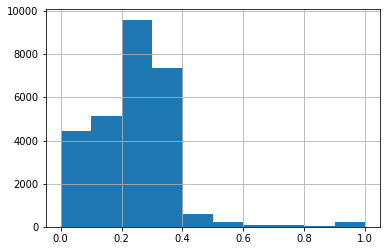

In [4]:
df_test['10ma_tgt'].hist().plot()

[]

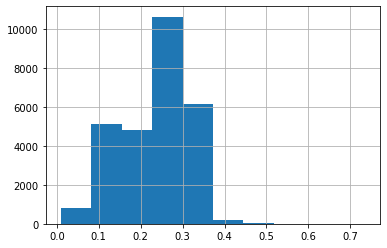

In [6]:
df_test['pred_tgt'].hist().plot()

In [3]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')

In [6]:
base_df['10ma_tgt'].describe()

count    100885.000000
mean          3.044470
std         142.362152
min           0.000000
25%           0.533611
50%           0.996001
75%           1.115014
max       27786.416545
Name: 10ma_tgt, dtype: float64